In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate
from collections import Counter
from utils import plot_counter, process_acled_csv
from sklearn.ensemble import ExtraTreesClassifier
from nlp_utils import get_sentiment, get_features, make_predictions
from sklearn.metrics import precision_score, recall_score, f1_score
from doc_utils import get_docs_by_location, get_docs_by_day, interleave_location_and_date
%load_ext autoreload

/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv("../../data/india-news-headlines.csv")

In [3]:
labels = process_acled_csv("../../data/1900-01-01-2019-03-23-India.csv",
                           top_locations=30,
                           end="31-dec-2018")

Data from 2016-01-01 to 2018-12-31  & Number of days - 1096


In [4]:
df["created_at"] = df["publish_date"]
del df["publish_date"]

In [5]:
df.head(5)

,headline_category,headline_text,created_at
0,sports.wwe,win over cena satisfying but defeating underta...,20010101
1,bollywood,Raju Chacha,20010102
2,unknown,Status quo will not be disturbed at Ayodhya; s...,20010102
3,unknown,Fissures in Hurriyat over Pak visit,20010102
4,unknown,America's unwanted heading for India?,20010102


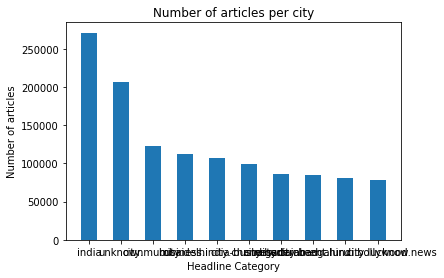

In [6]:
plot_counter(df.headline_category, 
             title="Number of articles per city",
             xlabel="Headline Category",
             ylabel="Number of articles")

In [7]:
df.head(5)

,headline_category,headline_text,created_at
0,sports.wwe,win over cena satisfying but defeating underta...,20010101
1,bollywood,Raju Chacha,20010102
2,unknown,Status quo will not be disturbed at Ayodhya; s...,20010102
3,unknown,Fissures in Hurriyat over Pak visit,20010102
4,unknown,America's unwanted heading for India?,20010102


In [8]:
def convert_to_datetime(df):
    """
    Input - A DF to convert df.publish_dates to to_datetime
    Returns - A converted DF
    """
    dates = df.created_at
    dates = dates.apply(lambda x: str(x))
    dates = pd.to_datetime(dates)
    df['created_at'] = dates
    return df


def filter_headlines(df, keywords):
    """
    Input - A DF for filtering headlines based on
            keywords
    Returns - Filtered DFA
    """
    assert(keywords != None)
    assert(len(keywords) != 0)

    if isinstance(keywords, str):
        keywords = [keywords]

    resultant_df = pd.DataFrame(df.head(1).copy(deep=True), df.columns)

    # Iteratively apply the filter for each word
    for keyword in keywords:
        temp_df = df[df['headline_text'].str.contains(keyword, na=False)]
        print(keyword, "found in", temp_df.shape[0], "rows")
        resultant_df = resultant_df.append(temp_df.copy(deep=True))

    curr_len = len(resultant_df)
    resultant_df.drop_duplicates(inplace=True)

    print("Dropped", curr_len - len(resultant_df), "duplicate rows")

    return resultant_df

In [9]:
df = convert_to_datetime(df)

filtered_df = filter_headlines(
    df, ['bjp', 'govt', 'government', 'elect',
         'riot', 'protest', 'unrest', 'politic',
         'violen', 'scam', 'gang', 'modi', 'attac'])
print("Current shape:", filtered_df.shape)

bjp found in 150 rows
govt found in 35274 rows
government found in 11661 rows
elect found in 22416 rows
riot found in 5056 rows
protest found in 18492 rows
unrest found in 532 rows
politic found in 10998 rows
violen found in 5588 rows
scam found in 11700 rows
gang found in 9349 rows
modi found in 890 rows
attac found in 22155 rows
Dropped 4634 duplicate rows
Current shape: (149630, 3)


In [10]:
# Get news from 2016 and with city tag
filtered_df = filtered_df[filtered_df.headline_category.str.contains(
    'city', na=False)]
filtered_df = convert_to_datetime(filtered_df)

filtered_df = filtered_df[filtered_df.created_at.dt.year > 2015]
print("Current shape:", filtered_df.shape)

Current shape: (33832, 3)


In [11]:
filtered_df.head(5)

,headline_category,headline_text,created_at
2457153,city.ahmedabad,bjp planning to advance gujarat assembly elect...,2016-12-19
2471496,city.mumbai,bjp silence on bmc pact worries senabjp silent...,2017-01-09
2475103,city.pune,bjp amp shiv sena hopeful of alliance for pimp...,2017-01-14
2476394,city.mumbai,hazare bjp mla get legal lessons over pilsanna...,2017-01-16
2477628,city.dehradun,protesting workers march to party office bjp r...,2017-01-18


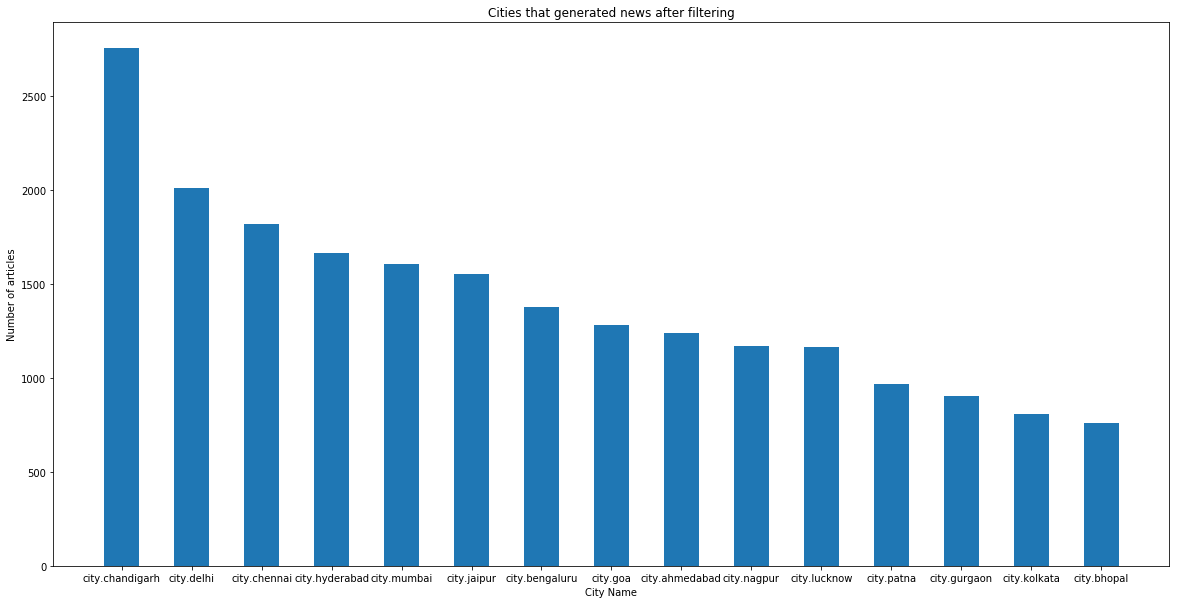

In [12]:
filtered_df.sort_values(by="created_at", inplace=True)

plot_counter(filtered_df.headline_category, num_elements=15, 
             title="Cities that generated news after filtering",
             xlabel="City Name", ylabel="Number of articles")

In [13]:
cities = pd.unique(filtered_df.headline_category)
for city in cities:
    if "." in city:
        city_df = filtered_df[filtered_df.headline_category == city]
        print(city)
        print("Min date:", min(city_df.created_at).date())
        print("Max date:", max(city_df.created_at).date())
        print()

city.chandigarh
Min date: 2016-01-01
Max date: 2018-12-31

city.jaipur
Min date: 2016-01-01
Max date: 2018-12-31

city.nagpur
Min date: 2016-01-01
Max date: 2018-12-26

city.trichy
Min date: 2016-01-01
Max date: 2018-12-28

city.vadodara
Min date: 2016-01-01
Max date: 2018-12-31

city.thiruvananthapuram
Min date: 2016-01-01
Max date: 2018-12-31

city.delhi
Min date: 2016-01-01
Max date: 2018-12-31

city.imphal
Min date: 2016-01-01
Max date: 2018-12-23

city.mumbai
Min date: 2016-01-01
Max date: 2018-12-29

city.chennai
Min date: 2016-01-01
Max date: 2018-12-31

city.indore
Min date: 2016-01-01
Max date: 2018-12-27

city.patna
Min date: 2016-01-01
Max date: 2018-12-31

city.hyderabad
Min date: 2016-01-01
Max date: 2018-12-30

city.gurgaon
Min date: 2016-01-01
Max date: 2018-12-29

city.goa
Min date: 2016-01-01
Max date: 2018-12-31

city.lucknow
Min date: 2016-01-01
Max date: 2018-12-31

city.pune
Min date: 2016-01-02
Max date: 2018-12-31

city.jamshedpur
Min date: 2016-01-02
Max date: 2

In [14]:
# Dictify cities
cities = {x: (x.split(".")[1]).title() for x in cities if "." in x}

# Delhi fix
cities["Delhi"] = "Delhi-New Delhi"

In [15]:
cities_set = set(cities.values())
acled_set = set(labels.keys())
common_locations = cities_set & acled_set

In [16]:
def get_headlines_sentiment(df):
    """
    Input - A dataframe of tweets from the CSV file
    Returns - A df with an extra sentiment column
    TODO - Process only for unique tweets
    """
    docs = df['headline_text']
    doc_ids = range(len(df))
        
    sentiment_dict = get_sentiment(docs, doc_ids)

    neg, pos, neu, compound = [], [], [], []

    for i in range(len(df)):
        row = df.iloc[i]
        doc_id = doc_ids[i]
        sentiment = sentiment_dict[doc_id]
        neg.append(sentiment['neg'])
        pos.append(sentiment['pos'])
        neu.append(sentiment['neu'])
        compound.append(sentiment['compound'])
    
    df['neg'] = neg
    df['neu'] = neu
    df['pos'] = pos
    df['compound'] = compound
    return df


In [ ]:
start_date, end_date = filtered_df.iloc[0]['created_at'], filtered_df.iloc[-1]['created_at']

try:
    temp = filtered_df.headline_category
    filtered_df["finallocation"] = temp
    del filtered_df["headline_category"]
except:
    pass

filtered_df = get_headlines_sentiment(filtered_df)

location_date_dict = interleave_location_and_date(filtered_df, start_date, end_date)

2016-01-01 00:00:00 2018-12-31 00:00:00
city.chandigarh


/Users/ateendraramesh/Desktop/CSE635/Election-Violence-Prediction/notebooks/doc_utils.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['date'] = dates


city.jaipur
city.nagpur
city.trichy
city.vadodara
city.thiruvananthapuram
city.delhi
city.imphal
city.mumbai
city.chennai
city.indore
city.patna
city.hyderabad
city.gurgaon
city.goa
city.lucknow
city.pune
city.jamshedpur
city.ahmedabad
city.kozhikode
city.bhubaneswar
city.visakhapatnam
city.navi-mumbai
city.kanpur
city.cuttack
city.kolkata
city.ludhiana
city.madurai
city.aurangabad
city.jammu
city.bhopal
city.noida


In [ ]:
location_feature_dict = {}
for location in location_date_dict:
    city = cities.get(location)
    if city is not None and city in common_locations:
        location_feature_dict[city] = get_features(location_date_dict[location])
        print(city, "done")

In [ ]:
make_predictions(location_feature_dict, labels)